First we install the loss function from the [Github repo](https://github.com/scandido/quantile-regression-tf), and then import packages.

In [ ]:
!pip install git+https://github.com/scandido/quantile-regression-tf.git

In [8]:
import matplotlib.pyplot as pl
import numpy as np
import tensorflow as tf
import tqdm
from quantile_regression_tf import QuantileLoss

To demonstrate using `QuantileLoss` to create a quantile regression, we create some arbitrary random process $y = f(x, r)$ where $r$ is a random variable.

In [9]:
def _f(x):
  return np.exp(0.4 * x) + 4 * x * np.random.uniform()

f = np.vectorize(_f)  # np.array([_f(x) for x in xs])

def sample_data(num_samples):
  xs = np.array([np.random.uniform(0, 10) for _ in range(num_samples)])
  ys = f(xs)  
  return xs, ys

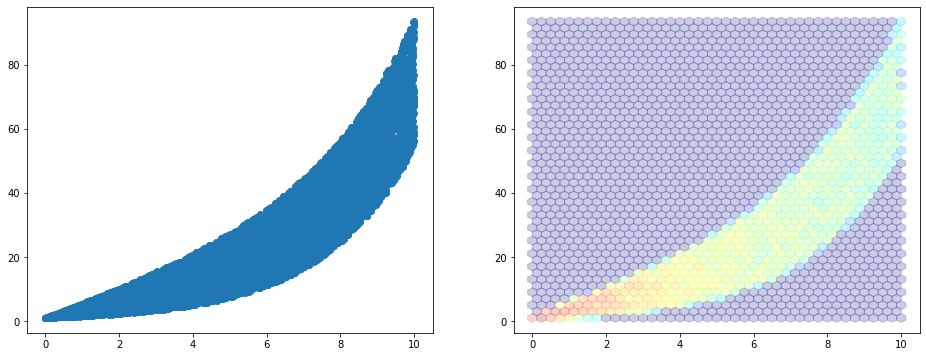

In [18]:
sample_x, sample_y = sample_data(num_samples=10000)

pl.figure(figsize=(16, 6))

pl.subplot(121)
pl.plot(sample_x, sample_y, 'o')

pl.subplot(122)
pl.hexbin(sample_x, sample_y, gridsize=40, cmap='jet', bins='log', alpha=0.2)

pl.show()

Now we create our deep quantile regression model. Start with a standard model and learning routine. 

Instead of our normal output layer with 1 head for the mean regression and using MSE for our loss, we use a dense layer with $n$ units for the $n$ quantiles. (Like normal regression this is a linear projection and we do not use an activation.) The neural network parameters holds our estimate of the value for `xx%` quantile.

We create a `QuantileLoss` object which holds the numeric values of the quantiles we want to regression on, e.g., `25%`, `50%`, and `75%`. In the example below we just pass the number of quantiles and the `QuantileLoss` chooses them to be evenly spaced.

The `QuantileLoss` object implements an efficient version of the classical quantile regression equations.

In [19]:
class QuantileRegressionLearner(tf.keras.Model):
  def __init__(
      self,
      network_width: int = 20,
      num_hidden_layers: int = 2,
      num_quantiles: int = 11,
      learning_rate: float = 0.01):
    super().__init__()

    self.hidden_layers = [
        tf.keras.layers.Dense(units=network_width, activation=tf.nn.relu)
        for _ in range(num_hidden_layers)]

    self.quantile_layer = tf.keras.layers.Dense(
        units=num_quantiles, activation=None)
    self.quantile_loss = QuantileLoss(num_quantiles)

    self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  def call(self, x: np.ndarray) -> tf.Tensor:
    for layer in self.hidden_layers:
      x = layer(x)
    return self.quantile_layer(x)

  def train(self, xs: np.ndarray, ys: np.ndarray) -> float:
    with tf.GradientTape() as tape:
      xs = np.expand_dims(xs, axis=1)
      ys = np.expand_dims(ys, axis=1)
      yp = self(xs, training=True)
      loss = self.quantile_loss(ys, yp)
      gradients = tape.gradient(loss, self.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    return float(np.mean(loss))

  def plot(self, xs: np.ndarray, ys: np.ndarray) -> None:
    xr = np.linspace(0, 10, 21)
    xr = np.expand_dims(xr, axis=1)
    yr = self(xr)
    xr = np.squeeze(xr)
    yr = np.squeeze(yr)
    pl.hexbin(xs, ys, gridsize=40, cmap='jet', bins='log', alpha=.2)
    for quantile, label in enumerate(self.quantile_loss.quantile_labels()):
      pl.plot(xr, yr[:, quantile], label=label)
    pl.legend()
    pl.show()

Train for a little bit, and then we can visualize the learned quantile values.

100%|██████████| 20000/20000 [02:36<00:00, 127.50it/s]


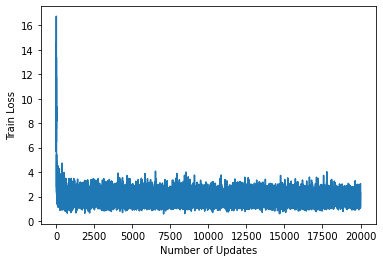

In [20]:
model = QuantileRegressionLearner()

loss = []
for _ in tqdm.tqdm(range(20000)):
  loss.append(model.train(*sample_data(num_samples=12)))

pl.plot(loss)
pl.xlabel('Number of Updates')
pl.ylabel('Train Loss')
pl.show()

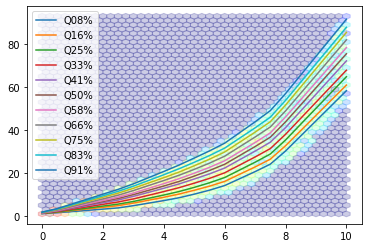

In [21]:
model.plot(*sample_data(num_samples=5000))